In [65]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [66]:
COLS = ["CorsikaId","px","py","pz","xprime","yprime","t",
        "shower_id","prm_id","prm_energy","prm_theta","prm_phi"]

## Creating a function to do the data wrangling for all the data sets

In [67]:
def wrangle(file_path):
    df = pd.read_csv(file_path, # path
                 comment="#", # ignore comments
                 sep=' ',# separation is space
                 header=None, # no other header set
                 names=COLS, # the name of the columns
                 engine="python" 
    )
    

    # computing the zenith angle in radians
    df['p'] = np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2)
    df['theta_rad'] = np.arccos(df['pz'] / df['p'])  # zenith angle in radians 

    # theta radians in degrees
    df['theta'] = np.rad2deg(df['theta_rad'])


    return df


In [68]:
chyulu = wrangle("../chyulu_1500m_15/chyulu_1500_E1_T15.shw")
chyulu.head()

,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,13,-0.081170,-0.175234,0.209441,7298.880,-12819.00,938.926,1,703,19.0406,40.198,142.721,0.284888,0.744879,42.678430
1,13,0.180082,0.204469,0.388038,-411.994,-2932.37,955.312,2,703,99.0012,40.678,-72.955,0.474142,0.612174,35.075005
2,5,0.185975,-1.838230,1.737850,-2693.500,-6053.16,952.556,2,703,99.0012,40.678,-72.955,2.536493,0.816002,46.753478
3,13,-0.232316,-0.163183,0.281824,-682.905,-10832.50,946.756,3,1105,30.5114,10.313,-96.213,0.400030,0.789068,45.210290
4,13,-0.278200,-0.249382,0.197184,-10699.600,-13938.60,931.773,4,1105,39.8523,38.274,-83.161,0.422455,1.085175,62.175976


In [69]:
print(len(chyulu))
print(f"Total showers in chyulu: {chyulu["shower_id"].nunique()}")


12934
Total showers in chyulu: 2290


In [70]:
lyon = wrangle("../lyon_237m_15/lyon_237m_E2_T15.shw")
lyon.head()

,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,1,-0.000357,0.000851,0.001545,-35.4737,822.540,955.947,1,703,557.786,27.053,-69.324,0.001800,0.538411,30.848681
1,1,-0.000273,-0.002782,0.004442,-1551.2400,792.155,955.762,1,703,557.786,27.053,-69.324,0.005249,0.561755,32.186170
2,1,0.000196,-0.001108,0.000283,-1438.5000,124.604,955.836,1,703,557.786,27.053,-69.324,0.001160,1.324501,75.888320
3,1,0.000516,-0.000086,0.000569,-1349.1100,913.191,955.792,1,703,557.786,27.053,-69.324,0.000773,0.743009,42.571257
4,1,0.000047,-0.000063,0.000097,-1505.7600,833.777,955.768,1,703,557.786,27.053,-69.324,0.000125,0.678913,38.898834


In [71]:
print(len(lyon))
print(f"Total showers in Lyon: {lyon["shower_id"].nunique()}")

8219
Total showers in Lyon: 1450


In [72]:
# subsetting the data for only muons and resetting the index
muons_lyon = (lyon["CorsikaId"] == 6)
lyon = lyon[muons].reset_index()

muons_chyulu = (chyulu["CorsikaId"] == 6)
chyulu = chyulu[muons_chyulu].reset_index()

In [73]:
def cos_squared_model(theta_deg, I0):
    """Cosine-power model with n fixed at 3: I(theta) = I0 * cos^2(theta)"""
    theta_rad = np.deg2rad(theta_deg)
    return I0 * np.cos(theta_rad)**2

In [74]:
# generating 100 values from 0 to 90 
theta_range = np.linspace(0, 90, 100)
 # binning the zenith angle
bins = np.arange(0, 91, 10)

Fitted I0 with n=3: 31.759 (in arbitrary units)
Fitted I0 with n=3: 22.829 (in arbitrary units)


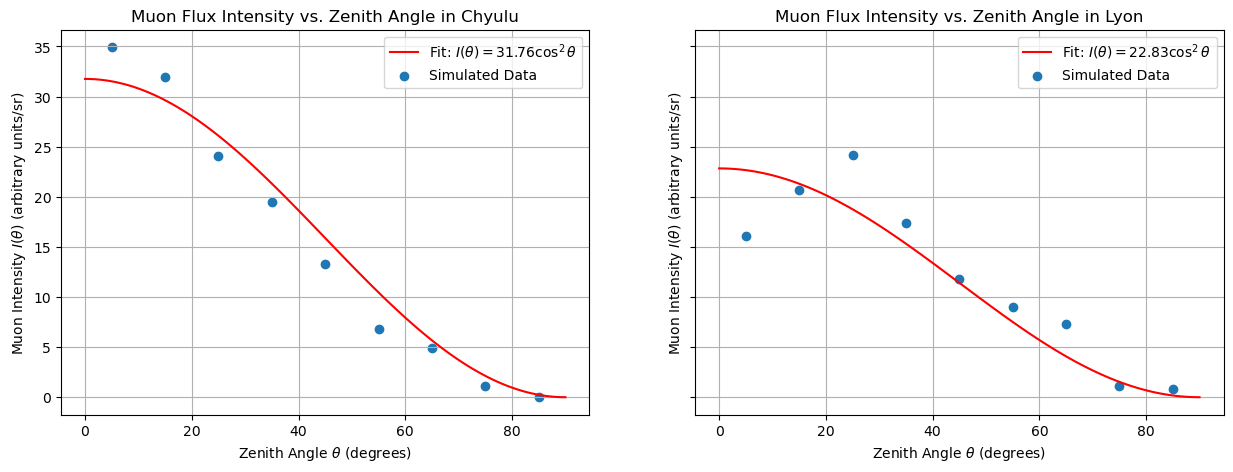

In [75]:
# creating the 3 plots in one row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True, sharex=True)

# zenith angles for chyulu
counts, bin_edges = np.histogram(chyulu['theta'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# calculating solid angle
bin_edges_rad = np.deg2rad(bin_edges) 
solid_angles = 2 * np.pi * (np.cos(bin_edges_rad[:-1]) - np.cos(bin_edges_rad[1:]))

# calculating flux intensity (input how long the simulation was running)
time = float(input("How long did the simulation run in Chyulu(s): "))
flux_intensity = counts / time / solid_angles



# fitting the binned data
try:
    popt, pcov = curve_fit(cos_squared_model, bin_centers, flux_intensity, p0=[1.0])
    I0_fit = popt[0]
    print(f"Fitted I0 with n=3: {I0_fit:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit = 1.0 # Default value if fit fails

# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit)


#plotting the curve on the same plot as 
axes[0].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[0].scatter(bin_centers, flux_intensity, label='Simulated Data')


# plotting the graph
axes[0].set_title('Muon Flux Intensity vs. Zenith Angle in Chyulu')
axes[0].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[0].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[0].legend()
axes[0].grid(True)

# ------------------------------------------------------------------------------

# zenith angles for lyon
counts_chyulu, bin_edges_chyulu = np.histogram(lyon['theta'], bins=bins)
bin_centers_chyulu = (bin_edges_chyulu[:-1] + bin_edges_chyulu[1:]) / 2.0

# calculating solid angle
bin_edges_rad_c = np.deg2rad(bin_edges_chyulu) 
solid_angles_chyulu = 2 * np.pi * (np.cos(bin_edges_rad_c[:-1]) - np.cos(bin_edges_rad_c[1:]))

# calculating flux intensity (input how long the simulation was running)
time_chyulu = float(input("How long did the simulation run in lyon(s): "))
flux_intensity_chyulu = counts_chyulu / time_chyulu / solid_angles_chyulu

# fitting the binned data
try:
    popt_chyulu, pcov_chyulu = curve_fit(cos_squared_model, bin_centers_chyulu, flux_intensity_chyulu, p0=[1.0])
    I0_fit_chyulu = popt_chyulu[0]
    print(f"Fitted I0 with n=3: {I0_fit_chyulu:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit_chyulu = 1.0 # Default value if fit fails


# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit_chyulu)


#plotting the curve on the same plot as 
axes[1].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit_chyulu:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[1].scatter(bin_centers_chyulu, flux_intensity_chyulu, label='Simulated Data')


# plotting the graph
axes[1].set_title('Muon Flux Intensity vs. Zenith Angle in Lyon')
axes[1].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[1].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[1].legend()
axes[1].grid(True)

# Print all graphs
plt.tight_layout
plt.show()

The difference in Muons in Chyulu and Lyon

In [76]:
print("--Lyon 237m E2 Time 15 secs-- \n")
top_shower_id_lyon = lyon["CorsikaId"].groupby(lyon["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_lyon = len(lyon)
print(f"Total Muon Distribution {muon_distribution_lyon} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_lyon}")

--Lyon 237m E2 Time 15 secs-- 

Total Muon Distribution 841 

Number  of unique shower ids in 491

 Top ten shower ids in lyon 
 shower_id
6       44
93      39
11      26
10      21
7       15
1389    12
152     10
1299     9
1112     8
500      7
Name: CorsikaId, dtype: int64


In [77]:
print("--Chyulu 1500m E1 Time 15 secs-- \n")
# groupby
top_shower_id_chyulu = chyulu["CorsikaId"].groupby(chyulu["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_chyulu = len(chyulu)
print(f"Total Muon Distribution {muon_distribution_chyulu} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_chyulu}")

--Chyulu 1500m E1 Time 15 secs-- 

Total Muon Distribution 874 

Number  of unique shower ids in 491

 Top ten shower ids in lyon 
 shower_id
426     23
26      13
1424    11
2140     9
1480     9
166      9
913      8
259      8
2251     7
149      7
Name: CorsikaId, dtype: int64


Lyon's (237m Altitude) Muon count is less than Chyulu(1500m Altitude) so we can safely say that our simulation run appropriately to our theoretical knowledge.